In [1]:
MODEL = "gpt2-xl"
N_DEV = 500

In [2]:
import csv
import jsonlines
import json
import torch
from torch import nn, optim
from transformers import AutoTokenizer, GPT2LMHeadModel, GPT2Tokenizer, GPTJForCausalLM
from tqdm import tqdm
import numpy as np
import os

from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
import pandas as pd
import scipy.stats

%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('png')

torch.manual_seed(0)
np.random.seed(0)

In [3]:
sns.set()
sns.set_style("white")
sns.set_style({'font.family':'serif', 'font.serif':'Times New Roman'})

In [4]:
def load_boolq(split, max_examples=None):
    data = jsonlines.open(f"boolean-questions/{split}.jsonl")
    questions = []
    for line in data:
        q = line["question"]
        q = f"{q}?"
        
        a_good = str(line["answer"]).lower()
        a_bad = "false" if a_good == "true" else "true"
        
        questions.append((q, a_good, a_bad))
        if max_examples is not None and len(questions) == max_examples:
            break
    np.random.shuffle(questions)
    return questions

def load_sciq(split, max_examples=None):
    questions = []
    with open(f"sciq/{split}.json") as reader:
        data = json.load(reader)
        
    for line in data:
        q = line["question"]
        
        a_good = line["correct_answer"]
        a_bad = line["distractor1"]
        
        questions.append((q, a_good, a_bad))
        if max_examples is not None and len(questions) == max_examples:
            break
    np.random.shuffle(questions)
    return questions

def load_creak(split, max_examples=None):
    questions = []
    reader = jsonlines.open(f"creak/data/creak/{split}.json")
    for line in reader:
        q = line["sentence"]
        a_good = line["label"]
        a_bad = "true" if line["label"] == "false" else "false"
        questions.append((q, a_good, a_bad))
    np.random.shuffle(questions)
    return questions
        
    

In [5]:
if MODEL.startswith("gpt2"):
    #lm = GPT2LMHeadModel.from_pretrained(MODEL).eval().cuda()
    tokenizer = GPT2Tokenizer.from_pretrained(MODEL)
elif MODEL == "gpt-j":
    #lm = GPTJForCausalLM.from_pretrained(
    #    "EleutherAI/gpt-j-6B",
    #    revision="float16",
    #    torch_dtype=torch.float16
    #).eval().cuda()
    tokenizer = AutoTokenizer.from_pretrained("EleutherAI/gpt-j-6B")

probe_layer = -1
probe_reduction = lambda tensor: tensor[:, -1, :]

In [6]:
def lm_pred(toks):
    results = lm(toks, labels=toks, output_hidden_states=True)
    assert toks.shape[0] == 1
    results.logprob = -results["loss"] * toks.shape[1]
    return results

@torch.no_grad()
def get_preds_and_reprs(data):
    ratios = []
    corrects = []
    qa_good_reprs = []
    qa_bad_reprs = []
    for q, a_good, a_bad in tqdm(data):
        qa_good_tok = tokenizer(f"{q} {a_good}", return_tensors="pt").input_ids.cuda()
        qa_good_pred = lm_pred(qa_good_tok)
        qa_good_repr = probe_reduction(qa_good_pred.hidden_states[probe_layer])

        qa_bad_tok = tokenizer(f"{q} {a_bad}", return_tensors="pt").input_ids.cuda()
        qa_bad_pred = lm_pred(qa_bad_tok)
        qa_bad_repr = probe_reduction(qa_bad_pred.hidden_states[probe_layer])
        
        ratios.append(qa_good_pred.logprob - qa_bad_pred.logprob)
        corrects.append(qa_good_pred.logprob > qa_bad_pred.logprob)
        qa_good_reprs.append(qa_good_repr)
        qa_bad_reprs.append(qa_bad_repr)
    return {
        "ratio": torch.tensor(ratios),
        "correct": torch.tensor(corrects),
        "good_repr": torch.cat(qa_good_reprs, dim=0),
        "bad_repr": torch.cat(qa_bad_reprs, dim=0)
    }

In [7]:
data = {
    dataset_name: {
        split_name: loader(split_name) for split_name in ["train", "valid"]
    }
    for dataset_name, loader in [("boolq", load_boolq), ("sciq", load_sciq), ("creak", load_creak)]
}

def process_data(data, suffix):
    data_path = f"cache/data_processed_{MODEL}{suffix}.pt"
    if os.path.exists(data_path):
        data_processed = torch.load(data_path)
    else:
        data_processed = {}

    changed = False
    for dataset_name, dataset in data.items():
        if dataset_name not in data_processed:
            data_processed[dataset_name] = {}
        for split_name, split_data in dataset.items():
            if split_name not in data_processed[dataset_name]:
                changed = True
                data_processed[dataset_name][split_name] = get_preds_and_reprs(split_data)

    if changed:
        torch.save(data_processed, data_path)
        
    return data_processed

data_processed = process_data(data, "")

## Probes are more accurate than models

In [8]:
class Probe(nn.Module):
    def __init__(self, model_dim):
        super().__init__()
        self.layer = nn.Linear(model_dim, 2)
    
    def forward(self, reprs):
        return self.layer(reprs)
    
    def predict(self, good_reprs, bad_reprs):
        return (self(good_reprs)[:, 1] > self(bad_reprs)[:, 1]).float()
    
@torch.no_grad()
def eval_probe(probe, data_processed):
    return probe.predict(
        data_processed["good_repr"],
        data_processed["bad_repr"]
    ).mean().item()

def train_probe(train_data_processed, val_data_processed):
    n_train, model_dim = train_data_processed["good_repr"].shape
    probe = Probe(model_dim).cuda()
    objective = nn.CrossEntropyLoss()
    opt = optim.Adam(probe.parameters(), lr=0.003)
    for i in range(200):
        loss_good = objective(probe(train_data_processed["good_repr"][:-N_DEV]), torch.ones(n_train-N_DEV).long().cuda())
        loss_bad = objective(probe(train_data_processed["bad_repr"][:-N_DEV]), torch.zeros(n_train-N_DEV).long().cuda())
        loss = loss_good + loss_bad
        opt.zero_grad()
        loss.backward()
        opt.step()
        if False:
            if (i+1) % 10  == 0:
                print(loss.item())
    return probe

#def plot_accuracy(model_preds, probe_preds):
#    df = pd.DataFrame({"model": model_preds > 0.5, "probe": probe_preds > 0.5})
#    sns.barplot(data=df)
#    plt.ylim(0.5, 1)
#    plt.show()
    

probes = {}
probe_preds = {}
probe_dev_preds = {}
for dataset in data:
    print(dataset)
    probe = train_probe(data_processed[dataset]["train"], data_processed[dataset]["valid"])
    probes[dataset] = probe
    probe_preds[dataset] = torch.sigmoid(
        probe(data_processed[dataset]["valid"]["good_repr"])[:, 1]
        - probe(data_processed[dataset]["valid"]["bad_repr"])[:, 1]
    ).detach().cpu().numpy()
    probe_dev_preds[dataset] = torch.sigmoid(
        probe(data_processed[dataset]["train"]["good_repr"][-N_DEV:])[:, 1]
        - probe(data_processed[dataset]["train"]["bad_repr"][-N_DEV:])[:, 1]
    ).detach().cpu().numpy()
    print("probe acc", eval_probe(probe, data_processed[dataset]["valid"]))
    print("model acc", data_processed[dataset]["valid"]["correct"].float().mean().item())
    #plot_accuracy(
    #    torch.sigmoid(data_processed[dataset]["valid"]["ratio"].float()),
    #    probe_preds[dataset]
    #)
    print()

boolq
probe acc 0.6293577551841736
model acc 0.6183485984802246

sciq
probe acc 0.7880000472068787
model acc 0.7609999775886536

creak
probe acc 0.635302722454071
model acc 0.5113056302070618



## Probes and predictions are sensitive to formatting!

In [9]:
tf_to_yn = lambda a: "yes" if a == "true" else "no"

formatters = {
    "qa": lambda q, ag, ab: (f"Q: {q} A:", ag, ab),
    "yn": lambda q, ag, ab: (q,  tf_to_yn(ag), tf_to_yn(ab)),
    "cap": lambda q, ag, ab: (q, ag.capitalize(), ab.capitalize()),
    "dot": lambda q, ag, ab: (q, ag + ".", ab + "."),
}
batch_format = lambda formatter, dataset: [formatter(*datum) for datum in dataset]

for format_name, formatter in formatters.items():
    data_fmt = {
        dataset_name: {
            split_name: batch_format(formatter, loader(split_name)) 
            for split_name in ["train", "valid"]
        }
        for dataset_name, loader in [("boolq", load_boolq), ("sciq", load_sciq), ("creak", load_creak)]
    }
    data_processed_fmt = process_data(data_fmt, f"_{format_name}")

    print(format_name)
    for dataset in data_fmt:
        print(dataset)
        probe = train_probe(data_processed_fmt[dataset]["train"], data_processed_fmt[dataset]["valid"])
        print("probe acc", eval_probe(probe, data_processed_fmt[dataset]["valid"]))
        print("model acc", data_processed_fmt[dataset]["valid"]["correct"].float().mean().item())
        print()
    print()

qa
boolq
probe acc 0.6299694180488586
model acc 0.621100902557373

sciq
probe acc 0.7790000438690186
model acc 0.7850000262260437

creak
probe acc 0.6301969289779663
model acc 0.5047410726547241


yn
boolq
probe acc 0.6256880760192871
model acc 0.41590213775634766

sciq
probe acc 0.0
model acc 0.0

creak
probe acc 0.6557257771492004
model acc 0.49161195755004883


cap
boolq
probe acc 0.5746177434921265
model acc 0.6186544299125671

sciq
probe acc 0.7940000295639038
model acc 0.7490000128746033

creak
probe acc 0.6374908685684204
model acc 0.5040116906166077


dot
boolq
probe acc 0.6348623633384705
model acc 0.5966360569000244

sciq
probe acc 0.784000039100647
model acc 0.7559999823570251

creak
probe acc 0.6498906016349792
model acc 0.4959883391857147




## Probe superiority seems mainly attributable to probe calibration

boolq


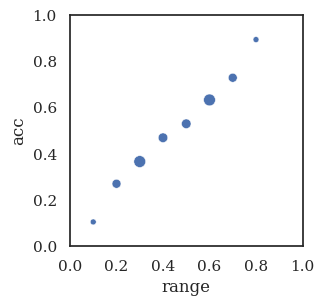

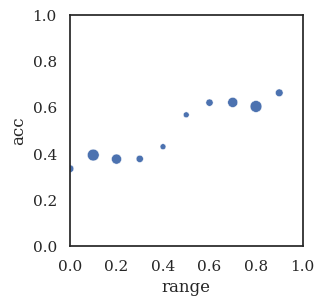

sciq


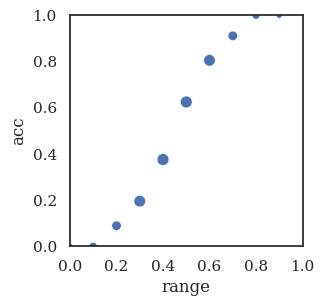

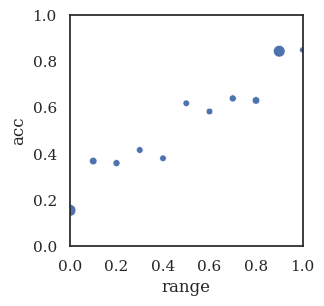

creak


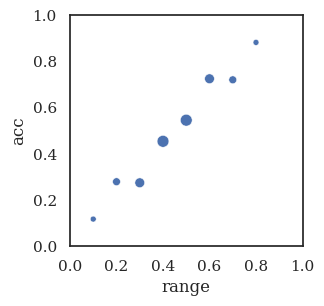

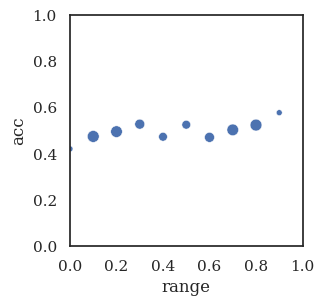

In [10]:
def plot_calibration(probe_preds):
    p_true = probe_preds
    p_false = 1 - p_true
    calib_range = []
    calib_acc = []
    calib_size = []
    step = 0.1
    for start in np.arange(0, 1 + step, step):
        end = start + step
        pred_true = ((start <= p_true) & (p_true < end)).sum()
        pred_false = ((start <= p_false) & (p_false < end)).sum()
        if pred_true + pred_false == 0:
            continue
        frac_true = pred_true / (pred_true + pred_false)
        calib_range.append(start)
        calib_acc.append(frac_true)
        calib_size.append(pred_true + pred_false)

    data = pd.DataFrame({"range": calib_range, "acc": calib_acc, "size": calib_size})
    fig, ax = plt.subplots(figsize=(3, 3))
    sns.scatterplot(ax=ax, data=data, x="range", y="acc", size="size")
    ax.get_legend().remove()
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.show()

for dataset in data:
    print(dataset)
    plot_calibration(probe_preds[dataset])
    plot_calibration(torch.sigmoid(data_processed[dataset]["valid"]["ratio"]).detach().cpu().numpy())

## Models are not strictly better than probes

boolq


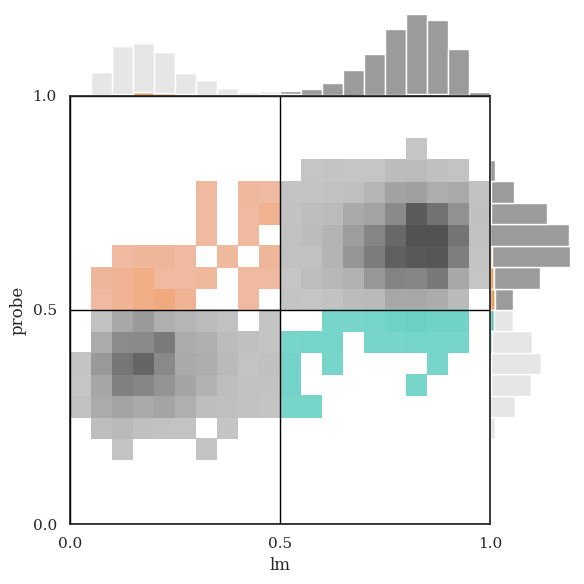

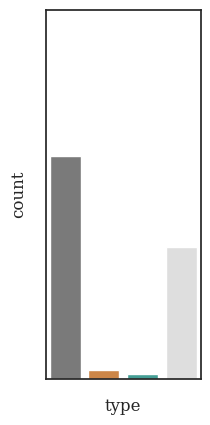

lm acc       0.618348623853211
probe acc    0.6293577981651376
ensemble acc 0.6293577981651376
sciq


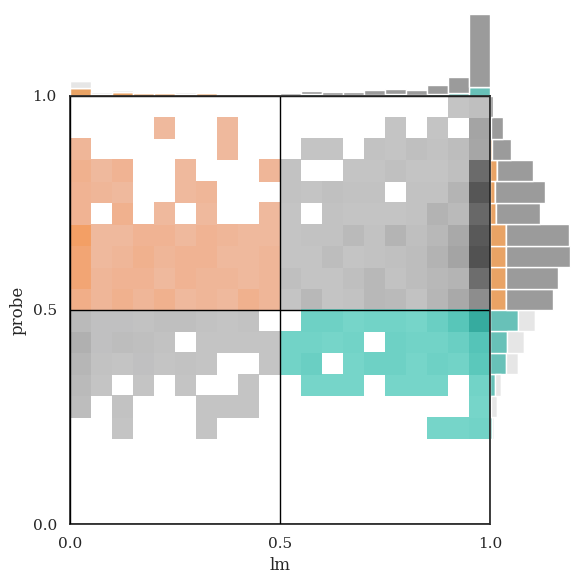

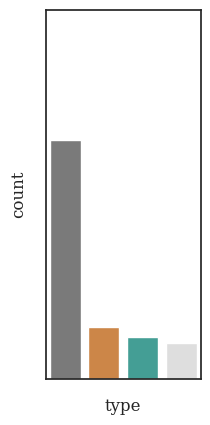

lm acc       0.761
probe acc    0.788
ensemble acc 0.797
creak


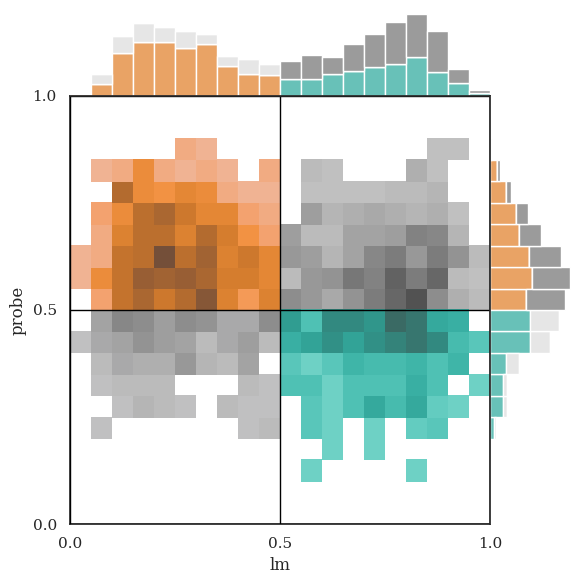

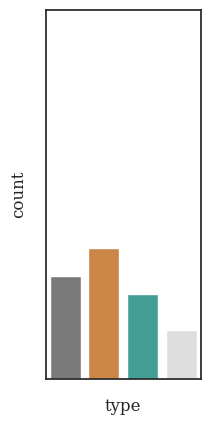

lm acc       0.5113056163384391
probe acc    0.6353026987600292
ensemble acc 0.6353026987600292


In [14]:
for dataset in data:
    lm_dev_preds = torch.sigmoid(data_processed[dataset]["train"]["ratio"][-N_DEV:]).detach().cpu().numpy()
    lm_preds = torch.sigmoid(data_processed[dataset]["valid"]["ratio"]).detach().cpu().numpy()
    lm_correct = lm_preds > 0.5
    probe_correct = probe_preds[dataset] > 0.5
    
    ensemble_scores = []
    for d in np.arange(0, 1, 0.05):
        dev_acc = ((d * lm_dev_preds + (1-d) * probe_dev_preds[dataset]) > 0.5).mean()
        acc = ((d * lm_preds + (1-d) * probe_preds[dataset]) > 0.5).mean()
        ensemble_scores.append((dev_acc, acc))
    ensemble_corrects = max(ensemble_scores)[1]
        
    lm_probe = lm_correct & probe_correct
    lm_noprobe = lm_correct & ~probe_correct
    nolm_probe = ~lm_correct & probe_correct
    nolm_noprobe = ~lm_correct & ~probe_correct
    cat_labels = 0 * lm_probe + 1 * nolm_probe + 2 * lm_noprobe + 3 * nolm_noprobe
    type_order = ["both right", "probe correct", "pred correct", "both wrong"]
    #palette = dict(zip(type_order, sns.husl_palette(5, h=0.1)))
    base_palette = sns.husl_palette(5, h=0.1)
    neutral = (.48, .48, .48)
    neutral_light = (0.87, 0.87, 0.87)
    palette = {"both right": neutral, "probe correct": base_palette[0], "pred correct": base_palette[2], "both wrong": neutral_light}
    names = dict(enumerate(type_order))
    #names = {0: "both right", 1: "pred correct", 2: "probe_correct", 3: "both wrong"}
    named_labels = [names[c] for c in cat_labels]
    
    print(dataset)
    
    df = pd.DataFrame({
        'lm': lm_preds,
        'probe': probe_preds[dataset],
        'type': named_labels,
    }).sort_values(by="type")
    
    g = sns.JointGrid(data=df, x="lm", y="probe", hue="type", xlim=(0, 1), ylim=(0, 1), space=0, palette=palette)
    g.plot_joint(
        sns.histplot, #discrete=(True, False),
        binrange=[0, 1],
        bins=20,
        #cmap="gist_gray_r",
    )
    g.plot_marginals(
        sns.histplot, multiple="stack",
        binrange=[0, 1],
        bins=20,
        #color="gray",

    )
    g.figure.axes[0].set_xticks([0, 0.5, 1])
    g.figure.axes[0].set_yticks([0, 0.5, 1])
    g.figure.axes[0].set_axisbelow(False)
    g.figure.axes[0].grid(color="black")
    g.figure.axes[0].get_legend().remove()
    #g.plot_joint(sns.scatterplot, sns.histplot)
    #g = sns.jointplot(data=df, x="lm", y="probe")
    plt.show()
    
    #sns.relplot(data=df, x='lm', y='probe', hue='type')
    #plt.xlim(0, 1)
    #plt.ylim(0, 1)
    #plt.show()
    
    fig, ax = plt.subplots(figsize=(2, 4.8))
    sns.countplot(ax=ax, data=df, x="type", order=type_order, palette=palette)
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    plt.ylim(0, len(df))
    plt.show()
    
    #print("lm & !probe", (lm_correct & (~probe_correct)).mean())
    #print("!lm & probe", ((~lm_correct) & probe_correct).mean())
    #print()
    print("lm acc      ", lm_correct.mean())
    print("probe acc   ", probe_correct.mean())
    print("ensemble acc", ensemble_corrects)


## When probe and model disagree, probe is just uncertain

In [ ]:
for dataset in data:
    print(dataset)
    print()
    lm_preds = torch.sigmoid(data_processed[dataset]["valid"]["ratio"].float()).detach().cpu().numpy()
    disagreements = (lm_preds > 0.5) ^ (probe_preds[dataset] > 0.5)
    disagree_prob_lm = abs(lm_preds[disagreements]-.5)
    disagree_prob_probe = abs(probe_preds[dataset][disagreements]-.5)
    disagree_acc_lm = (lm_preds[disagreements] > 0.5)
    disagree_acc_probe = (probe_preds[dataset][disagreements] > 0.5)
    agree_prob_lm = abs(lm_preds[~disagreements]-.5)
    agree_prob_probe = abs(probe_preds[dataset][~disagreements]-.5)
    print("lm disagree conf", disagree_prob_lm.mean(), disagree_prob_lm.std())
    print("probe disagree conf", disagree_prob_probe.mean(), disagree_prob_probe.std())
    print("lm agree conf", agree_prob_lm.mean(), agree_prob_lm.std())
    print("probe agree conf", agree_prob_probe.mean(), agree_prob_probe.std())
    print()
    
    print("lm disagree acc", disagree_acc_lm.mean())
    print("probe disagree acc", disagree_acc_probe.mean())
    print()
    
    print()

In [ ]:
labels = ["deception", "heterogeneity (probe)", "agreement (correct)", "confabulation", "agreement (uncertain)", "heterogeneity (query)", "agreement (incorrect)", "probe error (query uncertain)", "probe error (query correct)"]
dfs = []
for dataset in data:
    lm_preds = torch.sigmoid(data_processed[dataset]["valid"]["ratio"]).detach().cpu().numpy()
    
    lm_lc = lm_preds < 0.333
    lm_mc = (lm_preds >= 0.333) & (lm_preds < 0.667) #(0.333 <= lm_preds < 0.667)
    lm_hc = 0.667 <= lm_preds
    probe_lc = probe_preds[dataset] < 0.333
    probe_mc = (probe_preds[dataset] >= 0.333) & (probe_preds[dataset] < 0.667) # 0.333 <= probe_preds[dataset] < 0.667
    probe_hc = 0.667 <= probe_preds[dataset]
    
    deception = lm_lc & probe_hc
    het_p = lm_mc & probe_hc
    agr_c = lm_hc & probe_hc
    confab = lm_lc & probe_mc
    agr_u = lm_mc & probe_mc
    het_l = lm_hc & probe_mc
    agr_i = lm_lc & probe_lc
    probe_err_u = lm_mc & probe_lc
    probe_err_c = lm_hc & probe_lc
    
    cat_labels = (
        0 * deception
        + 1 * het_p
        + 2 * agr_c
        + 3 * confab
        + 4 * agr_u
        + 5 * het_l
        + 6 * agr_i
        + 7 * probe_err_u
        + 8 * probe_err_c
    )
    named_labels = [labels[c] for c in cat_labels]
    
    df = pd.DataFrame({
        'lm': ["gpt2-xl"] * len(lm_preds),
        'dataset': [dataset] * len(lm_preds),
        'type': named_labels,
    }).groupby("dataset")["type"].value_counts(normalize=True).rename("percent").reset_index()
    dfs.append(df)
    
palette = {
    "deception": "#E9A365",
    "heterogeneity (probe)": "#E9D165",
    "agreement (correct)": "#7A7A7A",
    "confabulation": "#F4D1B2",
    "agreement (uncertain)": "#ABABAB",
    "heterogeneity (query)": "#6EC168",
    "agreement (incorrect)": "#DEDEDE",
    "probe error (query uncertain)": "#CDEBE8",
    "probe error (query correct)": "#68C1B8",
}
#palette = sns.color_palette(palette)

    
g = sns.catplot(x="type", y="percent", col="dataset",
                data=pd.concat(dfs), kind="bar", palette=palette, order=labels)
g.set(xticklabels=[])
plt.ylim(0, 0.7)
plt.show()